# [RNN(Recurrent Neural Networks)](https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D)

## [LSTM(Long Short Term Memory)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   
> Vanilla RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있습니다. 이를 `vanishing gradient problem`이라고 합니다.    
  
이 문제를 극복하기 위해서 고안된 것이 바로 LSTM입니다.

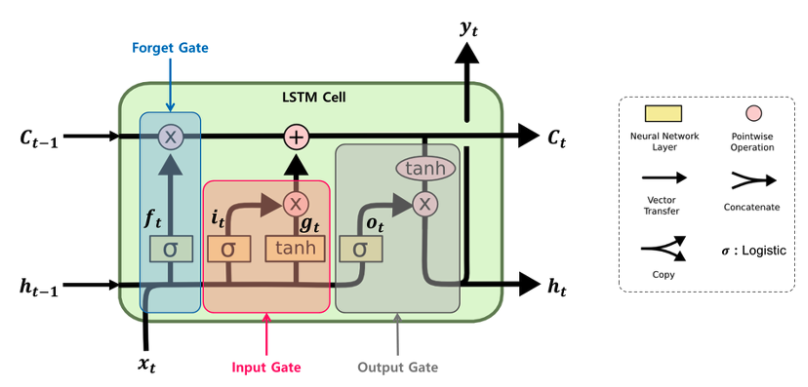

## GRU(Gated Recurrent Unit)
GRU는 LSTM과 비슷한 이유로 만들어졌으며, LSTM보다 구조가 단순하다.  
  
- Update Gate
  > LSTM의 Forget Gate와 Input Gate를 합친 Gate이다. 이전의 정보를 얼마나 통과시킬지 결정하는 Gate이다.  
- Reset Gate
  > 이전 hidden sate의 정보를 얼마나 잊을 지를 결정하는 Gate이다. Sigmoid 활성함수를 통과시켜 0 ~ 1 사이의 범위로 잊을 정보의 양을 결정한다.

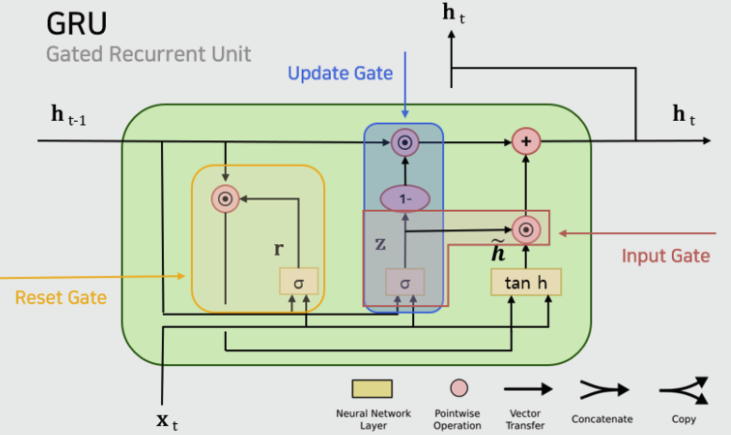

# Load Data

In [2]:
import numpy as np 
import pandas as pd 

import torch 
from torchtext.vocab import build_vocab_from_iterator

from tqdm.auto import tqdm

In [3]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive
    
    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


In [4]:
df_ko = pd.read_csv(DATA_PATH+"naver_review/naver_review_train.csv", sep="\t")

print(f'{df_ko.isnull().sum().sum()} / {df_ko.shape}') 
df_ko.head()

5 / (150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
df_ko = df_ko.dropna().reset_index(drop=True)

print(f'{df_ko.isnull().sum().sum()} / {df_ko.shape}') 
df_ko.head()

0 / (149995, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# Text Preprocessing

## Cleaning

In [6]:
df_ko['document'] = df_ko['document'].map(lambda x: x.strip())

print(f'{df_ko.isnull().sum().sum()} / {df_ko.shape}')
df_ko.head()

0 / (149995, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Tokenization

In [7]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 52.5 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-04-23 07:31:43--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbuc

In [8]:
from konlpy.tag import Mecab

mecab = Mecab()

In [9]:
tokens = mecab.pos(df_ko["document"][0])
len(tokens)

10

In [10]:
df_ko["document"][0]

'아 더빙.. 진짜 짜증나네요 목소리'

## Stemming / Stopword

In [11]:
def tokenizer(text):
    tokens = mecab.pos(text)
    return [ token[0] for token in tokens if token[1][0] in "NVJ"]

In [12]:
tokenizer(df_ko["document"][0])[:5]

['짜증', '나', '네요', '목소리']

In [13]:
def yield_tokens(data,tokenizer):
    for text in tqdm(data):
        yield tokenizer(text)

## 어휘집 생성 
- `<pad>(패딩)`: 0
- `<unk>(정의되지 않은 문자)`: 1

In [14]:
gen = yield_tokens(df_ko["document"],tokenizer) # 토큰화 
vocab = build_vocab_from_iterator(gen,specials=["<pad>","<unk>"]) # 어휘집 
vocab.set_default_index(vocab["<unk>"])
len(vocab)

  0%|          | 0/149995 [00:00<?, ?it/s]

41294

In [15]:
vocab(['짜증', '나', '네요', '목소리', 'karns'])

[143, 20, 199, 517, 1]

In [16]:
vocab.lookup_tokens([126, 18, 203, 682, 1, 0])

['연출', '봤', '준', '심리', '<unk>', '<pad>']

In [17]:
features = [ vocab(tokenizer(text)) for text in tqdm(df_ko["document"].tolist())]
len(features)

  0%|          | 0/149995 [00:00<?, ?it/s]

149995

## Padding

In [18]:
max_len = max(len(lst) for lst in features)
max_len

69

In [19]:
features = [ lst + [0] * (max_len - len(lst))  if len(lst) < max_len else lst for lst in tqdm(features)]
features = np.array(features)
features.shape

  0%|          | 0/149995 [00:00<?, ?it/s]

(149995, 69)

In [20]:
max_len == len(features[:1][0])

True

# Dataset

In [21]:
target = df_ko["label"].to_numpy()
target.shape

(149995,)

In [22]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self,x,y=None):
        self.x = x # features
        self.y = y.reshape(-1,1) # target

    def __len__(self):
        return self.x.shape[0]
        
    def __getitem__(self,idx):
        item = {}
        item["x"] = torch.LongTensor(self.x[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item

In [23]:
dt = ReviewDataset(features, target)
len(dt)

149995

# DataLoader

In [24]:
dl = torch.utils.data.DataLoader(dt,batch_size=256,shuffle=False)
len(dl)

586

In [25]:
batch = next(iter(dl))
batch['x'][:2], batch['y'][:2]

(tensor([[ 143,   20,  199,  517,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 350,  251,  466,    3,   76, 1191,   32,  586,  713,   27,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0]]),
 tensor([[0.],
         [1.]]))

# GRU Model

Parameters
- input_size : 피쳐개수
- hidden_size : 은닉상태의 출력개수
- batch_first : 입력 데이터가 batch 먼저일 경우 True , 입력길이가 먼저일경우 False 
  
Output
- output 
- hidden_state

In [26]:
import torch.nn as nn 
from torch.autograd import Variable

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [36]:
class GRU_net(nn.Module):
  def __init__(self, size_vocab, device, num_output=1, dim_embed=64, hidden_size=64, linear_size=64, num_layers=1):
    super().__init__()
    self.device = device 
    self.num_output = num_output 
    self.hidden_size = hidden_size 
    self.num_layers = num_layers 

    self.embed = nn.Embedding(size_vocab, dim_embed) 
    self.gru = nn.GRU(input_size=dim_embed, hidden_size=hidden_size, 
                        num_layers=num_layers)
    self.fclayer = nn.Linear(hidden_size, linear_size) 
    self.outlayer = nn.Linear(linear_size, num_output) 
  
  def forward(self, x): # (batch, seq_len)
    emb = self.embed(x) # (batch, seq_len, dim_embed)
    
    # 초기화 
    hidden_state = Variable(torch.zeros(self.num_layers, emb.size(0),
                                  self.hidden_size, requires_grad=True)).to(self.device)

    out, hidden_state = self.gru(emb.transpose(1,0), hidden_state)
    h = hidden_state[-1] # 마지막 hidden 값만 사용 
    
    h = self.fclayer(h).relu()
    predict = self.outlayer(h) 
    return predict

In [37]:
model = GRU_net(len(vocab), device).to(device)
model

GRU_net(
  (embed): Embedding(41294, 64)
  (gru): GRU(64, 64)
  (fclayer): Linear(in_features=64, out_features=64, bias=True)
  (outlayer): Linear(in_features=64, out_features=1, bias=True)
)

In [38]:
batch["x"].to(device).shape 

torch.Size([256, 69])

In [39]:
model(batch["x"].to(device)).shape

torch.Size([256, 1])

# Engine

In [40]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0 
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device)) 
        loss = loss_fn(pred, batch["y"].to(device)) 
        
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step()
        
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader) 

    return epoch_loss 

In [41]:
from sklearn.metrics import accuracy_score

@torch.inference_mode()
def test_loop(dataloader,model,loss_fn,device):
    epoch_loss = 0
    total_acc = 0
    model.eval()

    pred_list = []
    sig = torch.nn.Sigmoid()

    for batch in dataloader:
        
        pred = model(batch["x"].to(device))
        
        pred_ = sig(pred)
        pred_ = pred_.to("cpu").numpy() 
        pred_list.append(pred_)

        if batch.get("y") is not None: 
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()
            
            pred_ = (pred_ > 0.5).astype(int)
            total_acc += accuracy_score(batch["y"].to("cpu").numpy(), pred_)

    epoch_loss /= len(dataloader)
    total_acc /= len(dataloader)

    # epoch_pred = np.concatenate(pred_list) 
    return epoch_loss , total_acc 

# random_split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_tr, X_te, y_tr, y_te = train_test_split(features, target, test_size=0.1, shuffle=True)

In [44]:
len(X_tr), len(y_tr), len(X_te), len(y_te)

(134995, 134995, 15000, 15000)

In [45]:
X_tr[0], y_tr[0]

(array([   3,   19, 4907,    5,   73,    9,  106, 1976,   83,   31,    2,
         751,  158,  161,  161,  161,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]),
 0)

# KFold

In [46]:
from sklearn.model_selection import KFold, StratifiedKFold

SEED = 42
n_splits = 5
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

# Train

In [47]:
from torch.utils.data import DataLoader

In [49]:
best_score_list = []
epochs = 100
batch_size = 256 #128
vocab_size = len(vocab) 

loss_fn = torch.nn.BCEWithLogitsLoss()

for i,(tri,vai) in enumerate(cv.split(X_tr)):
    model = GRU_net(vocab_size, device).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    
    train_dt = ReviewDataset(X_tr[tri],y_tr[tri])
    valid_dt = ReviewDataset(X_tr[vai],y_tr[vai])
    train_dl = DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    best_score = 0
    patience = 0

    for epoch in tqdm(range(epochs)):
        
        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device )
        valid_loss , score = test_loop(valid_dl, model, loss_fn, device  )
        
        patience += 1
        if best_score < score:
            print(f'best score: {train_loss, valid_loss, score}') # 트레인 로스, 벨리드 로스, 스코어 
            patience = 0
            best_score = score
            # torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 20:
            break
            
    print(f"Fold ({i}), BEST ACC: {best_score}")
    best_score_list.append(best_score)

  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.596647185525058, 0.46204374871164, 0.7774958007967337)
best score: (0.428697282033509, 0.4215809632584734, 0.7993062643689551)
best score: (0.3798621447306674, 0.4024551395537718, 0.8113511029411765)
best score: (0.34360714111989143, 0.40092632343184276, 0.8150161155263992)
best score: (0.3129643992790114, 0.4004039019346237, 0.8187895146266053)
Fold (0), BEST ACC: 0.8187895146266053


  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.5567926747539033, 0.4537000703924107, 0.7793897777271286)
best score: (0.416123369152512, 0.42070629742910276, 0.7993375416204218)
best score: (0.3713651649053628, 0.41086100210558696, 0.8089244837085777)
best score: (0.3384578013660218, 0.41287431345795683, 0.8102399863247185)
best score: (0.3070887241035841, 0.409867580206889, 0.8115297858530204)
Fold (1), BEST ACC: 0.8115297858530204


  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.5855943145345173, 0.46693394600220445, 0.774051896702077)
best score: (0.42863198839375194, 0.429962065703464, 0.7961995971737751)
best score: (0.38015746801950356, 0.4162669131216013, 0.8071611899476772)
best score: (0.3454560092275177, 0.4196138775573586, 0.8087938005390836)
best score: (0.3140330370427308, 0.4177133269467444, 0.8126207735452671)
Fold (2), BEST ACC: 0.8126207735452671


  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.6088859583670494, 0.4771790844651888, 0.7688849566949421)
best score: (0.43357917355700126, 0.44163950265578505, 0.7902017971103535)
best score: (0.38081626608190944, 0.41426182074366874, 0.8065749737394958)
best score: (0.3444392641926829, 0.41145401180915114, 0.8107079063936895)
best score: (0.3133722508052514, 0.42124891056204744, 0.8140781076581577)
Fold (3), BEST ACC: 0.8140781076581577


  0%|          | 0/100 [00:00<?, ?it/s]

best score: (0.5720695264249052, 0.4598089293488916, 0.7781402360472491)
best score: (0.42310488887872744, 0.4204217977118942, 0.8038479690225147)
best score: (0.3758120413216369, 0.40873121146885855, 0.8120401315007134)
best score: (0.34068170034489925, 0.4131044543014382, 0.8131311191929602)
best score: (0.30936136576942924, 0.4108706901095948, 0.8173578836015538)
Fold (4), BEST ACC: 0.8173578836015538


# Test

In [50]:
test_dt = ReviewDataset(X_te,y_te)
test_dl = DataLoader(test_dt, batch_size=batch_size,shuffle=False)

loss , pred = test_loop(test_dl, model, loss_fn, device  )

loss, pred 

(0.9674790228827524, 0.7967042540142729)